# Generation and post-analysis in metabric dataset 

#### Associated publication
Reference: https://www.nejm.org/doi/full/10.1056/NEJM199709113371101

In [1]:
import pandas as pd
import torch

from utils import data_processing, visualization

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## 1. Original data loading, analysis and visualization

### 1.1. Experiment setting - links to data

In [2]:
dataset_name = "Metabric"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = "dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

### 1.2. Loading, feature analysis, and visualization of original data: control vs treated group

In [3]:
metabric_control_fnames = ['time', 'censor'] + pd.read_csv(feat_types_file_control)["name"].to_list()[1:]
metabric_control = pd.read_csv(data_file_control, header=None, names=metabric_control_fnames)
print(metabric_control.head())

        time  censor  age_at_diagnosis  type_of_breast_surgery  cellularity  \
0  84.633333       1             43.19                       0            0   
1   7.800000       0             78.77                       1            2   
2  99.533333       0             89.08                       0            2   
3  36.566667       0             86.41                       0            2   
4  36.266667       0             84.22                       1            0   

   er_status  her2_status_measured_by_snp6  her2_status  \
0          1                             2            0   
1          1                             2            0   
2          1                             2            0   
3          1                             0            0   
4          1                             1            0   

   inferred_menopausal_state  lymph_nodes_examined_positive  oncotree_code  \
0                          1                              0              1   
1             

In [4]:
# Load and transform control data
data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, feat_types_file_control, miss_file, true_miss_file)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, miss_file, true_miss_file)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [5]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=metabric_control_fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=metabric_control_fnames)

# Update dataframe
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

## 2. Training and generation from the generative model

Possible generative models: HI-VAE (our), survival_gan, survival_ctgan, survival_nflow, survae (synthcity)

In [6]:
from execute import surv_hivae, surv_gan, surv_vae
generators_dict = {"HI-VAE" : surv_hivae, 
                   "Surv-GAN" : surv_gan, 
                   "Surv-VAE" : surv_vae}

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [7]:
# the datasets used for training is data_init_control
n_generated_dataset = 100

T_surv = torch.Tensor(df_init_control.time)
T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
n_intervals = 10
T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]

generators_sel = ["HI-VAE", "Surv-GAN", "Surv-VAE"]
data_gen_control_dict = {}
for generator_name in generators_sel:
    print("=" * 100)
    print("Generate data by " + generator_name)
    if generator_name in ["HI-VAE"]:
        data_gen_control_dict[generator_name] = generators_dict[generator_name].run((data_init_control_encoded, intervals), miss_mask_control, true_miss_mask_control, feat_types_file_control, feat_types_dict, n_generated_dataset, )
    else:
        data_gen_control_dict[generator_name] = generators_dict[generator_name].run(data_init_control, columns=metabric_control_fnames, target_column="censor", time_to_event_column="time", n_generated_sample=n_generated_dataset)

Generate data by HI-VAE
Epoch: [ 0]  time: 0.3261, ELBO_train: -16.73549779, KL_z: 0.75778433, KL_s: 0.03294365, reconstruction loss: -15.94476981
Epoch: [100]  time: 8.5871, ELBO_train: -12.00282319, KL_z: 0.68720239, KL_s: 0.12055705, reconstruction loss: -11.19506375
Epoch: [200]  time: 17.0648, ELBO_train: -11.84912268, KL_z: 0.94714662, KL_s: 0.13565266, reconstruction loss: -10.76632340
Epoch: [300]  time: 26.5117, ELBO_train: -11.75637341, KL_z: 1.16972386, KL_s: 0.14608250, reconstruction loss: -10.44056705
Epoch: [400]  time: 36.6042, ELBO_train: -11.67020448, KL_z: 1.30468882, KL_s: 0.14518714, reconstruction loss: -10.22032852
Training finished.
Generate data by Surv-GAN


[2025-05-15T09:58:06.284759+0200][1225][CRITICAL] load failed: Failed to import transformers.trainer because of the following error (look up to see its traceback):
Failed to import transformers.integrations.integration_utils because of the following error (look up to see its traceback):
Failed to import transformers.modeling_tf_utils because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.
[2025-05-15T09:58:06.285598+0200][1225][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2025-05-15T09:58:06.285857+0200][1225][CRITICAL] module plugin_great load failed
[2025-05-15T09:58:06.294633+0200][1225][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[202

Generate data by Surv-VAE


 40%|████      | 400/1000 [01:52<02:48,  3.55it/s]


In [8]:
# Convert generated data into dataframe
df_gen_control_dict = {}
df_syn_dict = {}
for generator_name in generators_sel:
    list_df_gen_control = []
    data_syn = []
    for j in range(n_generated_dataset):
        df_gen_control_j = pd.DataFrame(data_gen_control_dict[generator_name][j].numpy(), columns=metabric_control_fnames)
        df_gen_control_j['treatment'] = 0
        list_df_gen_control.append(df_gen_control_j)
        data_syn.append(pd.concat([df_init_treated, df_gen_control_j], ignore_index=True))
        
    df_gen_control_dict[generator_name] = list_df_gen_control
    df_syn_dict[generator_name] = data_syn

### 3. Compare generation performance

#### 3.1. General metrics

In [9]:
from utils.metrics import general_metrics
general_scores = []
for generator_name in generators_sel:
    general_scores.append(general_metrics(df_init_control, df_gen_control_dict[generator_name], generator_name))
general_scores_df = pd.concat(general_scores)

##### 3.1.1. Data resemblance

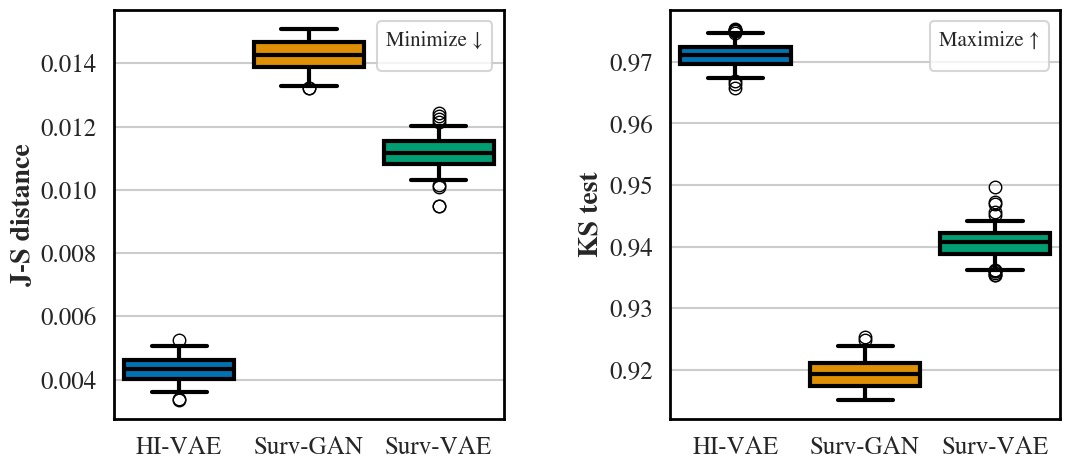

In [10]:
from utils.visualization import visualize_general_perf
visualize_general_perf(general_scores_df, metrics=[['J-S distance', "min"], ['KS test', "max"]])

##### 3.1.2. Utility

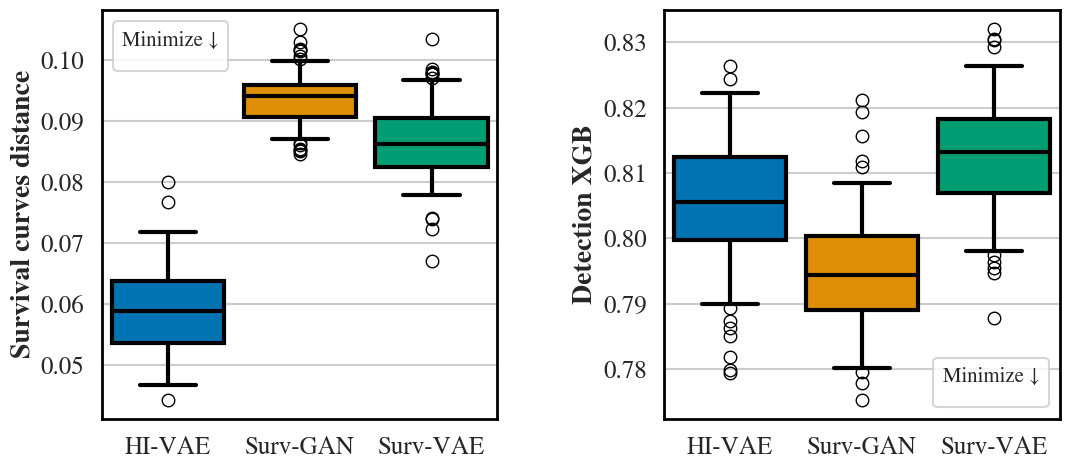

In [11]:
visualize_general_perf(general_scores_df, metrics=[['Survival curves distance', "min"], ['Detection XGB', "min"]])

#### 3.1.3. Privacy

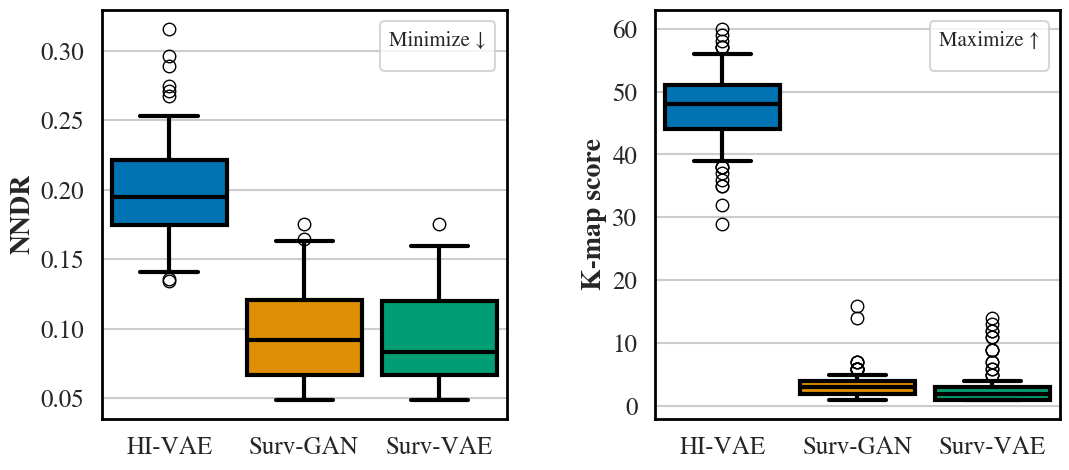

In [12]:
visualize_general_perf(general_scores_df, metrics=[['NNDR', "min"], ['K-map score', "max"]])

#### Replicability metrics

In [16]:
from utils.metrics import replicability
replicability_scores = []
for generator_name in generators_sel:
    replicability_scores.append(replicability(df_init, df_syn_dict[generator_name], generator_name))
replicability_scores_df = pd.concat(replicability_scores, ignore_index=True)

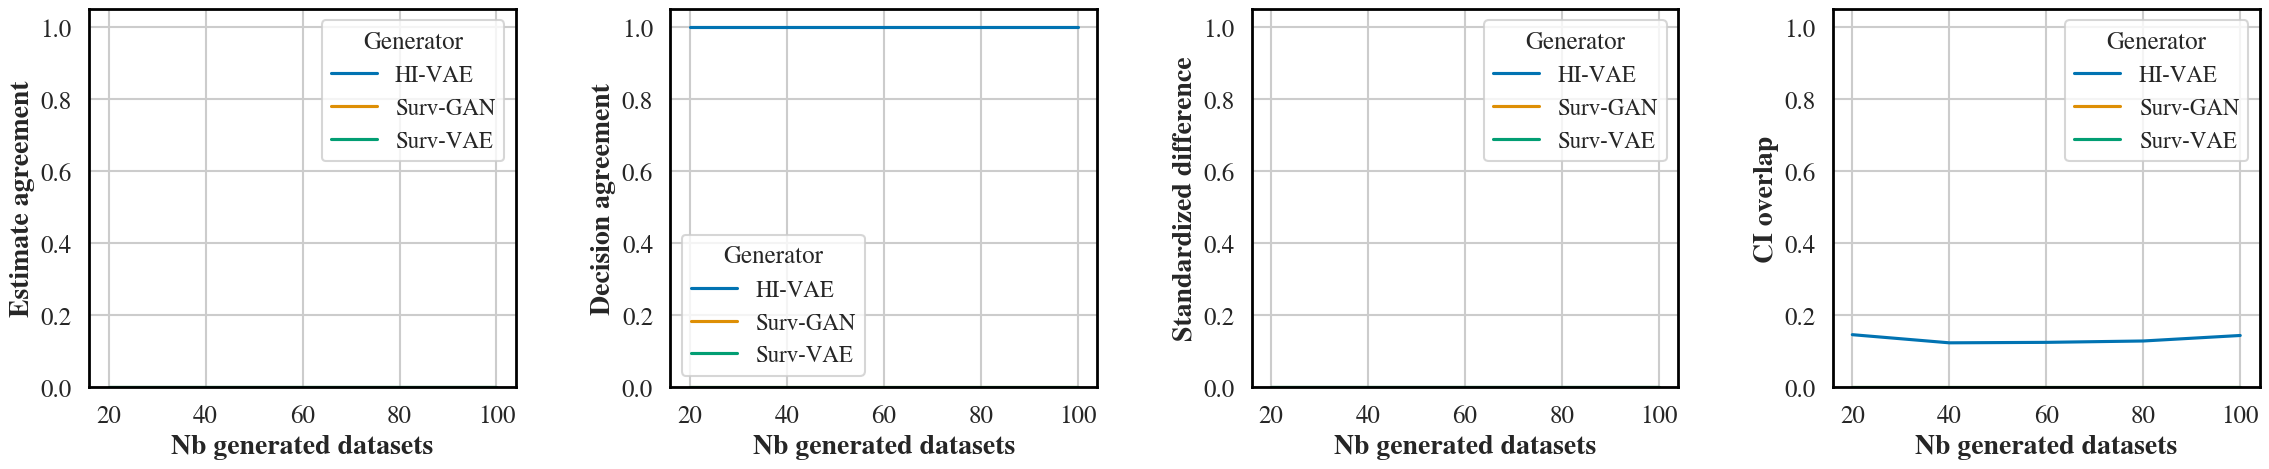

In [17]:
from utils.visualization import visualize_replicability_perf
visualize_replicability_perf(replicability_scores_df)

In [18]:
replicability_scores_df

,Generator,Nb generated datasets,Estimate agreement,Decision agreement,Standardized difference,CI overlap
0,HI-VAE,20,0,1,0,0.145508
1,HI-VAE,40,0,1,0,0.122886
2,HI-VAE,60,0,1,0,0.124189
3,HI-VAE,80,0,1,0,0.127979
4,HI-VAE,100,0,1,0,0.143281
5,Surv-GAN,20,0,0,0,0.000000
6,Surv-GAN,40,0,0,0,0.000000
7,Surv-GAN,60,0,0,0,0.000000
8,Surv-GAN,80,0,0,0,0.000000
9,Surv-GAN,100,0,0,0,0.000000
